# Earthquake_standardization (guebin)
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연, 최규빈
- categories: [Graph Laplacian, PCA, eigendecomposition]

In [1]:
import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx

In [3]:
import time 

In [4]:
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

In [5]:
from haversine import haversine

##### 1. Data

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

In [7]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]

In [8]:
N=len(_df)

##### 2. $f(x)$ 

In [112]:
f_true = _df.loc[:,"Magnitude"]

In [113]:
f = (f_true-f_true.mean())/f_true.std()

In [8]:
f@f ## SST 

4515.999999999998

In [9]:
(f-np.mean(f))@(f-np.mean(f)) ## SSE

4515.999999999998

In [10]:
(f*0-np.mean(f))@(f*0-np.mean(f)) ## SSH

1.788340861072209e-29

##### 3. Haversine Fomula 사용한 거리 정의

In [15]:
# def dist(i,j):
#     lat = np.array(_df.Latitude)
#     long = np.array(_df.Longitude)
#     return haversine((lat[i],long[i]),(lat[j],long[j]))

In [16]:
locations = np.array(_df.iloc[:,[1,2]])

In [17]:
dist_matrix = np.zeros((N,N))

In [18]:
for i in range(N):
    for j in range(i,N): 
        dist_matrix[i,j]=haversine(locations[i],locations[j])

In [19]:
dist_matrix = dist_matrix + dist_matrix.T

In [20]:
dist_matrix

array([[    0.        ,  5961.60560635, 10594.64532549, ...,
          283.48765909, 10831.08154775,  5512.17788275],
       [ 5961.60560635,     0.        , 15875.7469962 , ...,
         5819.50260123,  6953.06020638,  9935.96013871],
       [10594.64532549, 15875.7469962 ,     0.        , ...,
        10636.49108416, 12127.14372591,  9114.83672805],
       ...,
       [  283.48765909,  5819.50260123, 10636.49108416, ...,
            0.        , 10553.19437367,  5793.83248054],
       [10831.08154775,  6953.06020638, 12127.14372591, ...,
        10553.19437367,     0.        , 16312.45397939],
       [ 5512.17788275,  9935.96013871,  9114.83672805, ...,
         5793.83248054, 16312.45397939,     0.        ]])

##### 4. Definition of a weighted adjacency matrix $W$

$$W_{u,v}=\begin{cases}{exp(-\frac{[dist(u,v)]^2}{2\theta^2})} & \quad \text{if } dist(u,v) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [21]:
# def weight(i,j,theta=100000,kappa=100000):
#     return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

In [272]:
theta,kappa = 5000, 100000

In [273]:
W = np.exp( -(dist_matrix/theta)**2)

(array([10841178.,  1969350.,  1480598.,  1008046.,   847840.,   747678.,
          679964.,   598564.,   718380.,  1511691.]),
 array([1.11428422e-07, 1.00000100e-01, 2.00000089e-01, 3.00000078e-01,
        4.00000067e-01, 5.00000056e-01, 6.00000045e-01, 7.00000033e-01,
        8.00000022e-01, 9.00000011e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

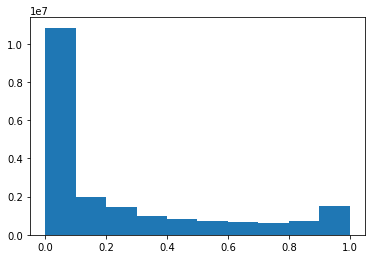

In [274]:
plt.hist(W.reshape(-1))

##### 5. The weight edge function with temporal edge $(v_t,v_{t+1})$

$$W_{u_r,v_s}=\begin{cases} {W_{u,v}} & \quad \text{ if }  u,v \in V_t  \\ W_{u,v} \odot \beta  & \quad \text{if }u=v \text{ and } r=s-1 \\ 0 & \quad \text{otherwise} \end{cases}$$

In [275]:
# def beta(i,j,b):
#     if _df.Year[i] == _df.Year[j]:
#         return 1
#     elif abs(int(_df.Year[i]) - int(_df.Year[j])) == 1:
#         return b
#     else:
#         return 0

In [276]:
_df.groupby("Year").aggregate(len)

,Date,Latitude,Longitude,Magnitude
Year,,,,
2004,571,571,571,571
2005,533,533,533,533
2006,508,508,508,508
2007,608,608,608,608
2008,508,508,508,508
2009,517,517,517,517
2010,560,560,560,560
2011,712,712,712,712


In [277]:
Nlst = _df.groupby("Year").aggregate(len).Date.tolist()
Nlst = [0]+np.cumsum(Nlst).tolist()

In [278]:
Nlst

[0, 571, 1104, 1612, 2220, 2728, 3245, 3805, 4517]

In [279]:
beta =np.zeros((N,N))
beta

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [280]:
for i in range(len(Nlst)-1):
    beta[Nlst[i]:Nlst[i+1],Nlst[i]:Nlst[i+1]]= 1

In [281]:
beta

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [282]:
W = W * beta

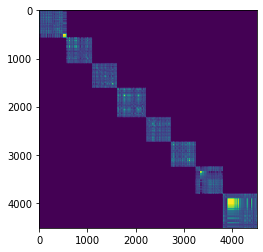

In [283]:
plt.imshow(W)

##### 6. Definition of Graph Laplacian matrix
- $L = D - W$

In [284]:
d = W.sum(axis=1)
D = np.diag(d)

In [285]:
#L = D - W
L = np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d))

##### 7. Eigendecomposition
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [286]:
λ, Ψ = np.linalg.eig(L)

In [287]:
Λ = np.diag(λ)

##### 8. Principal components Analysis

- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, n$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [288]:
fhats=[np.outer( Ψ.real[:,i], Ψ.real[:,i]) @ f for i in tqdm.tqdm(range(N))]
fhats=np.array(fhats)

100%|██████████| 4517/4517 [02:47<00:00, 27.00it/s]


In [306]:
fhats.sum(axis=1)

array([-3.14177377e+01,  2.35078786e+00, -6.17243810e-01, ...,
       -9.22920450e-08, -5.02777717e-08, -1.35695836e-08])

In [289]:
powers=np.apply_along_axis(lambda x: np.sum(x**2), 1, fhats)

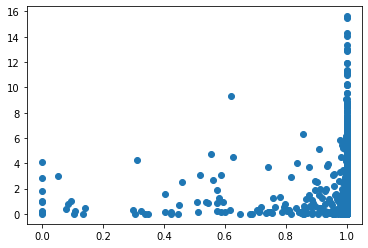

In [290]:
plt.plot(λ,powers,'o')

In [291]:
powers[powers>1].sum() / powers.sum()

0.8016982954456664

In [292]:
sum(powers>1)

1381

In [293]:
fhats2=fhats.copy()

In [294]:
fhats2[np.where(powers<1)]=0

In [295]:
fhats2

array([[-6.54309557e-02, -6.52829220e-02, -3.41066218e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.21769993e-02,  4.11878944e-05, -1.56734109e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.91099820e-02, -2.33977849e-04, -1.53497150e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

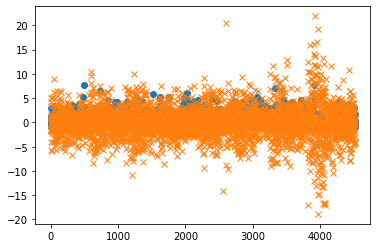

In [302]:
plt.plot(f,'o')
plt.plot(fhats.sum(axis=0),'x')

In [233]:
(np.argwhere(powers>1).reshape(-1)<1000).sum()

255

In [234]:
np.argwhere(powers>1)

array([[   0],
       [   3],
       [   7],
       ...,
       [4511],
       [4515],
       [4516]])

In [ ]:
def p(i):
    return np.sum((f @ np.outer( Ψ[:,i], Ψ[:,i]))**2)

In [ ]:
array_1 = np.array([p(i) for i in range(N)])

In [ ]:
varprop = array_1/array_1.sum()
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [ ]:
array_1

In [ ]:
_df["comp1"] = f @ np.outer( Ψ[:,0], Ψ[:,0])
_df["comp2"] = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])
_df["comp3"] = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])
_df["comp4"] = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])
_df["comp5"] = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])
_df["comp6"] = f @ np.outer( Ψ[:,_indexlst[4]], Ψ[:,_indexlst[4]])
_df["comp7"] = f @ np.outer( Ψ[:,_indexlst[5]], Ψ[:,_indexlst[5]])

##### **2004**, $n=571$

In [ ]:
_G1 = nx.Graph(_W[:len(_df.query('Year<="2004"')),:len(_df.query('Year<="2004"'))]-np.identity(len(_df.query('Year=="2004"'))))
_pos1 = nx.spring_layout(_G1,iterations=20)
m_pos1 = list(zip(_df.query('Year=="2004"').Longitude,_df.query('Year=="2004"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.query('Year=="2004"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2005**, $n=533$

In [ ]:
_G2 = nx.Graph(_W[len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"')),len(_df.query('Year<="2004"')):len(_df.query('Year<="2005"'))]-np.identity(len(_df.query('Year=="2005"'))))
_pos2 = nx.spring_layout(_G2,iterations=20)
m_pos2 = list(zip(_df.query('Year=="2005"').Longitude,_df.query('Year=="2005"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.query('Year=="2005"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2006**, $n=512$

In [ ]:
_G3 = nx.Graph(_W[len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"')),len(_df.query('Year<="2005"')):len(_df.query('Year<="2006"'))]-np.identity(len(_df.query('Year=="2006"'))))
_pos3 = nx.spring_layout(_G3,iterations=20)
m_pos3 = list(zip(_df.query('Year=="2006"').Longitude,_df.query('Year=="2006"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G3,m_pos3,node_color=_df.query('Year=="2006"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2007**, $n=608$

In [ ]:
_G4 = nx.Graph(_W[len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"')),len(_df.query('Year<="2006"')):len(_df.query('Year<="2007"'))]-np.identity(len(_df.query('Year=="2007"'))))
_pos4 = nx.spring_layout(_G4,iterations=20)
m_pos4 = list(zip(_df.query('Year=="2007"').Longitude,_df.query('Year=="2007"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp3,node_size =10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G4,m_pos4,node_color=_df.query('Year=="2007"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2008**, $n=508$

In [ ]:
_G5 = nx.Graph(_W[len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"')),len(_df.query('Year<="2007"')):len(_df.query('Year<="2008"'))]-np.identity(len(_df.query('Year=="2008"'))))
_pos5 = nx.spring_layout(_G5,iterations=20)
m_pos5 = list(zip(_df.query('Year=="2008"').Longitude,_df.query('Year=="2008"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G5,m_pos5,node_color=_df.query('Year=="2008"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2009**, $n=517$

In [ ]:
_G6 = nx.Graph(_W[len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"')),len(_df.query('Year<="2008"')):len(_df.query('Year<="2009"'))]-np.identity(len(_df.query('Year=="2009"'))))
_pos6 = nx.spring_layout(_G6,iterations=20)
m_pos6 = list(zip(_df.query('Year=="2009"').Longitude,_df.query('Year=="2009"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G6,m_pos6,node_color=_df.query('Year=="2009"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2010**, $n=560$

In [ ]:
_G7 = nx.Graph(_W[len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"')),len(_df.query('Year<="2009"')):len(_df.query('Year<="2010"'))]-np.identity(len(_df.query('Year=="2010"'))))
_pos7 = nx.spring_layout(_G7,iterations=20)
m_pos7 = list(zip(_df.query('Year=="2010"').Longitude,_df.query('Year=="2010"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G7,m_pos7,node_color=_df.query('Year=="2010"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

##### **2011**, $n=712$

In [ ]:
_G8 = nx.Graph(_W[len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"')),len(_df.query('Year<="2010"')):len(_df.query('Year<="2011"'))]-np.identity(len(_df.query('Year=="2011"'))))
_pos8 = nx.spring_layout(_G8,iterations=20)
m_pos8 = list(zip(_df.query('Year=="2011"').Longitude,_df.query('Year=="2011"').Latitude))

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp1,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp2,node_size = 10,ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp3,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp4,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp5,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp6,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
#collapse
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G8,m_pos8,node_color=_df.query('Year=="2011"').comp7,node_size = 10, ax=ax,cmap='bwr')
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()